In [163]:
from datetime import datetime
import os
import numpy as np
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv

In [164]:
# The variables we expect to be loaded in .env (or Jupyter runtime environment)
# PATH_TO_INPUT_CSV=str representing filepath of input PG&E Green Button Hourly CSV
load_dotenv()

True

In [275]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [16.0, 6.0]

## Load PG&E data from disk

In [165]:
df_csv = pd.read_csv(os.getenv('PATH_TO_INPUT_CSV'))

In [213]:
features_to_copy = {
    'date': 'DATE',
    'start_time': 'START TIME',
    'usage_kwh': 'USAGE',
    'cost_display': 'COST',
}

features = {
    'dt': lambda df: df.apply(lambda row: datetime.strptime(f'{row.date}T{row.start_time}', '%Y-%m-%dT%H:%M'), axis=1),
    'day_of_year': lambda df: df.dt.apply(lambda d: d.dayofyear),
    'day_of_week': lambda df: df.dt.apply(lambda d: d.dayofweek),
    'week_of_year': lambda df: df.dt.apply(lambda d: d.weekofyear),
    'year': lambda df: df.dt.apply(lambda d: d.year),
    'month': lambda df: df.dt.apply(lambda d: d.month),
    'hour': lambda df: df.dt.apply(lambda d: d.hour),
    'cost_cents': lambda df: df.cost_display.apply(lambda c: int(float(c[1:]) * 100))
}

In [214]:
df_energy = pd.DataFrame()

In [215]:
for newattr, oldattr in features_to_copy.items():
    df_energy[newattr] = df_csv[oldattr]

for attr, transform in features.items():
    df_energy[attr] = transform(df_energy)

### Quick sanity check of data

<AxesSubplot:xlabel='month', ylabel='usage_kwh'>

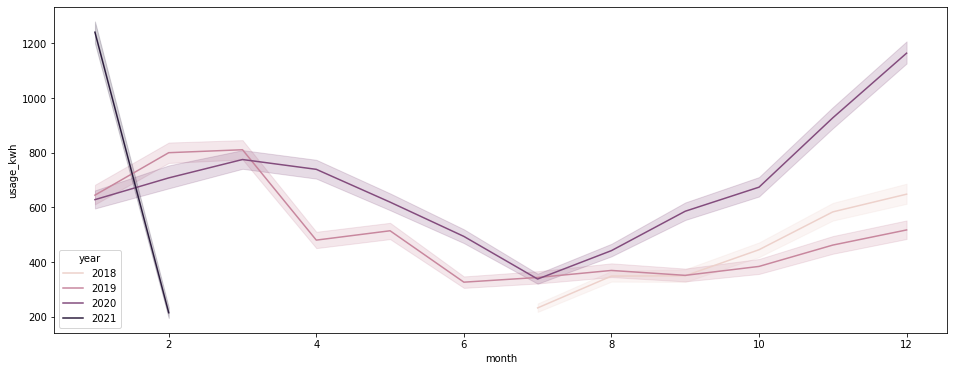

In [276]:
sns.lineplot(data=df_energy, x='month', y='usage_kwh', hue="year", estimator=np.sum)

<AxesSubplot:xlabel='month', ylabel='cost_cents'>

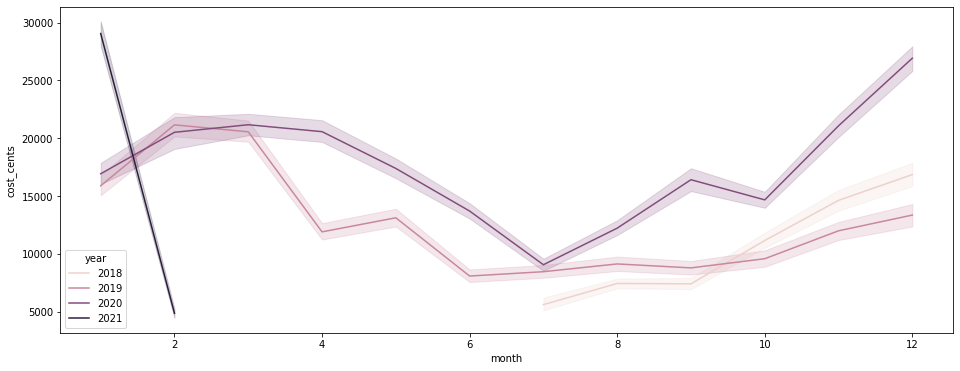

In [277]:
sns.lineplot(data=df_energy, x='month', y='cost_cents', hue="year", estimator=np.sum)

## Get the weather

We'll fetch the weather from the [Meteostat service](https://dev.meteostat.net/python/hourly.html#example).

You'll want to adjust the city/location in the `Point` constructor below, and add your custom query bounds.

In [218]:
import sys
!{sys.executable} -m pip install meteostat > /dev/null

In [219]:
from meteostat import Point, Hourly

In [220]:
# Adjust this for your desired location
oakland = Point(lat=37.8060361, lon=-122.2135176, alt=10)

# Adjust this to the bounds of your data set.
query_start = datetime(2018, 1, 1)
query_end =  datetime.now()

In [221]:
data = Hourly(oakland, query_start, query_end)
df_weather = data.fetch()

### Quick sanity check

In [222]:
df_weather['rolling_3hr_temp'] = df_weather.temp.rolling(3, min_periods=1).mean()

<AxesSubplot:xlabel='time', ylabel='rolling_3hr_temp'>

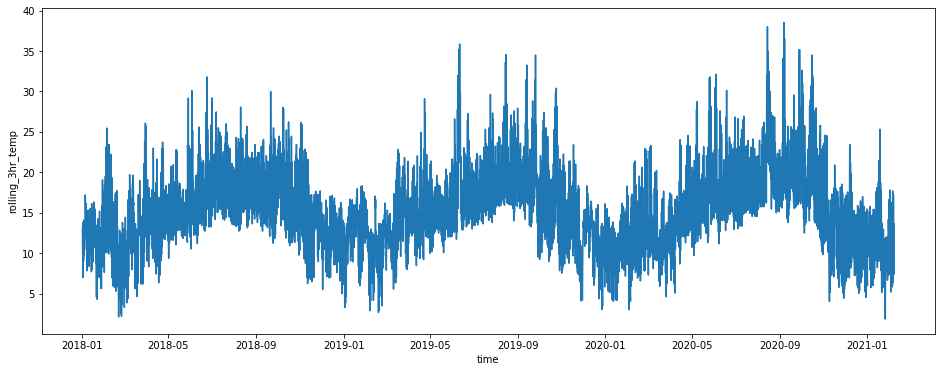

In [278]:
sns.lineplot(data=df_weather, x='time', y='rolling_3hr_temp')

## Merge data sets

In [224]:
df = df_weather.join(df_energy.set_index('dt'))

In [225]:
# Filter out na values
df = df[df.usage_kwh.notna()]

## Initial investigations

Let's just do a sanity check of our data.

In [226]:
corr = df.corr()

<AxesSubplot:>

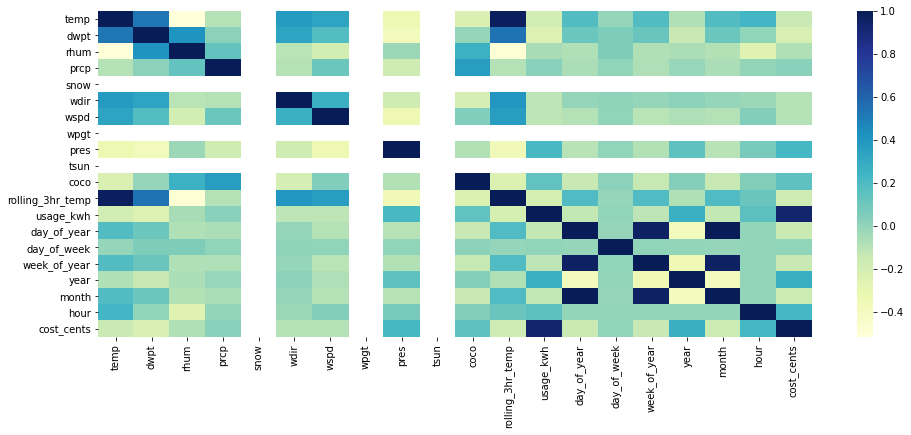

In [279]:
sns.heatmap(corr, cmap="YlGnBu")

I'm not seeing much correlation here, with the exception perhaps of pressure and usage

In [347]:
def plot_hour(hour):
    df_hourly = df[df.hour == hour].reset_index().copy()
    df_hourly['usage_kwh_rolling'] = df_hourly.usage_kwh.rolling(7).mean()
    sns.lineplot(data=df_hourly[df_hourly.hour == hour], x='index', y='usage_kwh_rolling', hue='year', estimator=np.sum).set_title(f'Usage at {hour}:00')

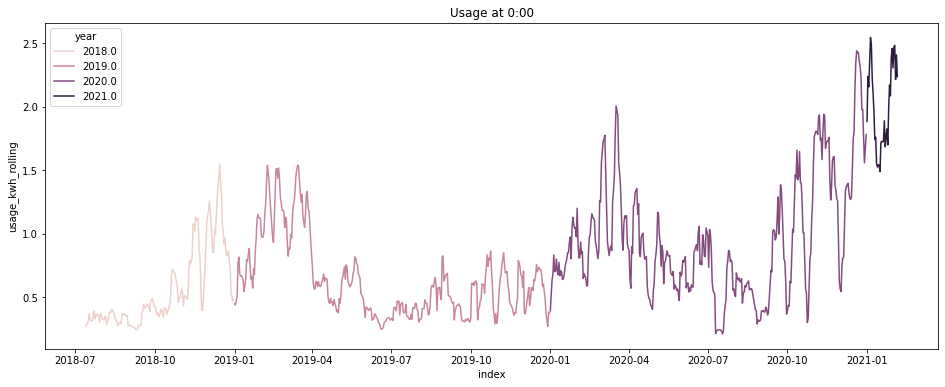

In [348]:
plot_hour(0)

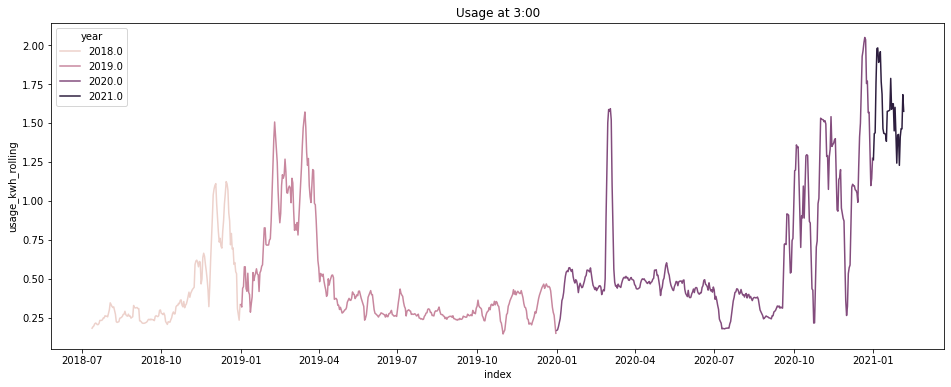

In [349]:
plot_hour(3)

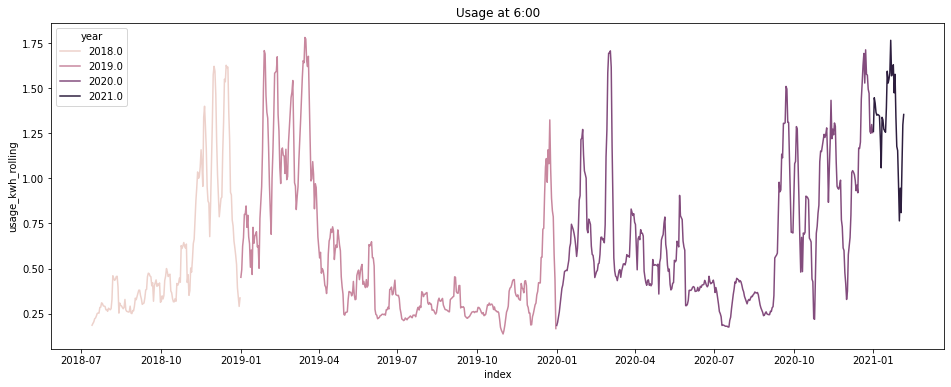

In [350]:
plot_hour(6)

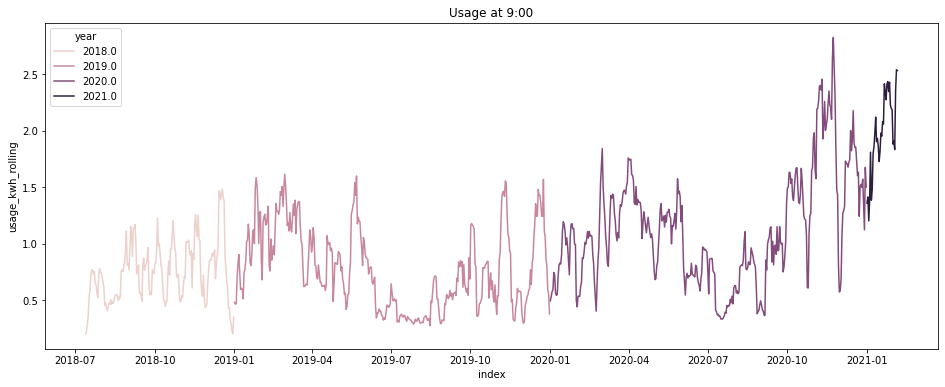

In [351]:
plot_hour(9)

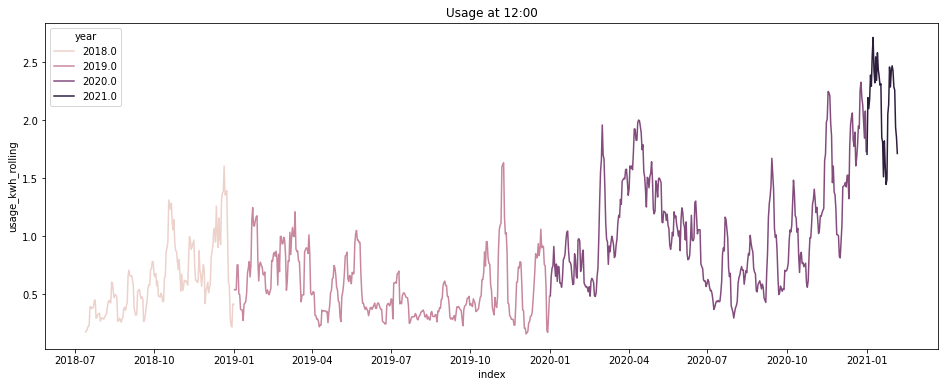

In [352]:
plot_hour(12)

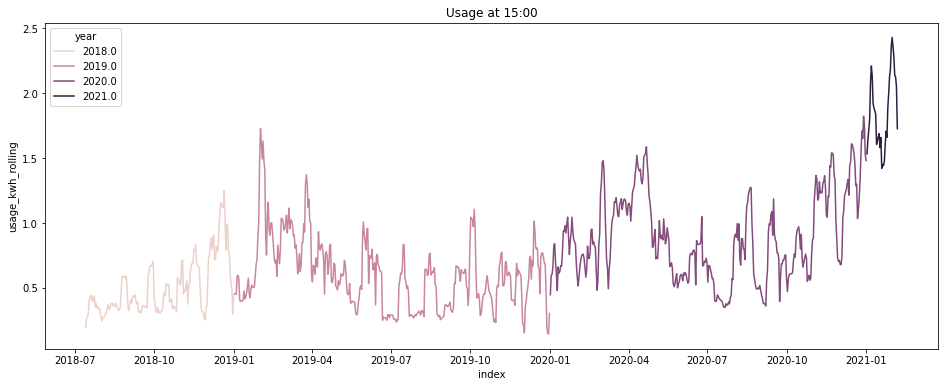

In [353]:
plot_hour(15)

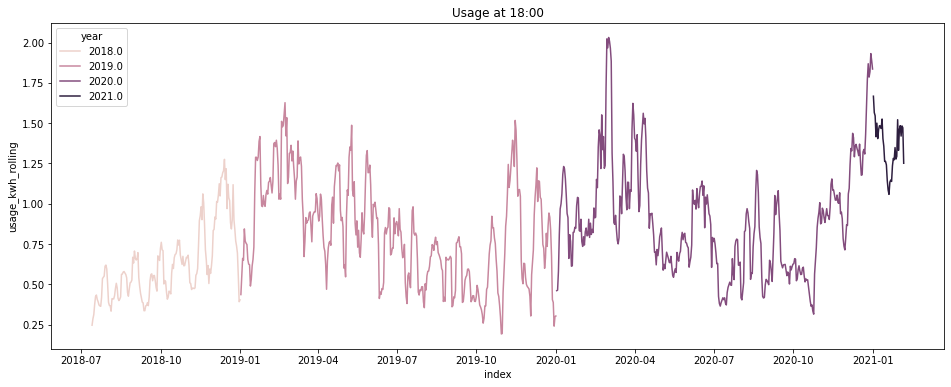

In [354]:
plot_hour(18)

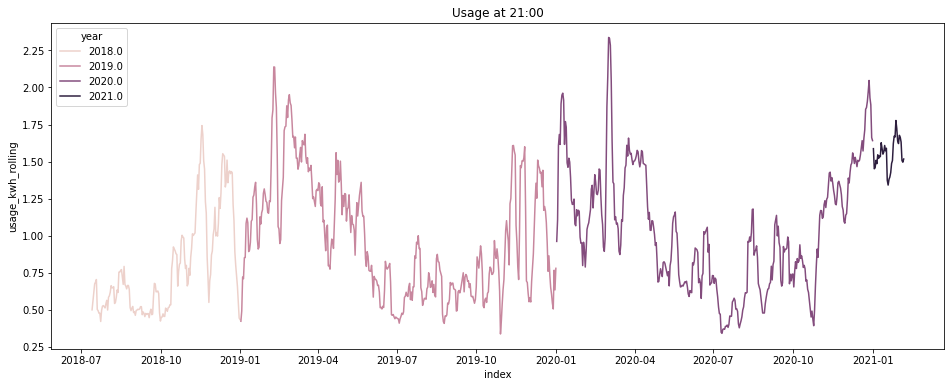

In [355]:
plot_hour(21)